In [4]:
import sys
import os

sys.path.append('scripts')

import re
import json
import argparse
import itertools
from pathlib import Path
import collections
from concurrent.futures import ProcessPoolExecutor


import statistics
from tabulate import tabulate


import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import PathPatch
from matplotlib.path import get_path_collection_extents
import seaborn as sns
import pandas as pd
import polars as pl

from rich import print, pretty
from typing import  Iterable
import pretty_errors
from catppuccin import PALETTE

print(os.getcwd())

# import .scripts.ldj
from ldj import ldj
from utils import *

pretty.install()

RESULTS_DIRS = [
    Path('./experiments/collaborative-gp'),
]

for RESULTS_DIR in RESULTS_DIRS:
    assert RESULTS_DIR.is_dir() and RESULTS_DIR.exists()

flavor = PALETTE.latte.colors
# num-robots-10-seed-0.json
RE = re.compile(r"tracking-(.+?)-sigma-tracking-(\d+.\d+)-seed-(\d+).json")


/home/jens/repos/master/gbp-rs

In [5]:
# use LaTeX for text with matplotlib
sns.set_style("darkgrid")
# set background color of sns darkgrid to flavor.base.hex
plt.rcParams['axes.facecolor'] = flavor.base.hex
# set font color to flavor.text.hex
plt.rcParams['text.color'] = flavor.text.hex

font_dirs = ["./scripts/fonts/"]
# go through all fonts in the font directory and add them
for font_dir in font_dirs:
    for font in os.listdir(font_dir):
        fm.fontManager.addfont(f"{font_dir}/{font}")

prop_jbm = fm.FontProperties(fname='./scripts/fonts/JetBrainsMonoNerdFontMono-Regular.ttf')
prop = fm.FontProperties(fname='./scripts/fonts/STIXTwoText-VariableFont_wght.ttf')

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": prop.get_name(),
    # "font.family": "stix",
    # "font.sans-serif": prop.get_name(),
    "mathtext.fontset": "stix",
    # "text.latex.preamble": r"\usepackage{fontenc}\usepackage{fontspec}\setmainfont{JetBrainsMonoNerdFontMono-Regular}",
})

print(prop.get_name())

colors = [
    (flavor.lavender.hex, 1.0, (1, 0), 'o'),
    (flavor.teal.hex, 1.0, (2, 2), 'X'),
    (flavor.green.hex, 1.0, (2, 2), 'X'),
]

STIX Two Text

In [47]:
def collision_happened_at_start(collision):
    collision = collision['aabbs'][0]
    min = np.array(collision['mins'])
    max = np.array(collision['maxs'])

    average = (min + max) / 2

    y_cut = 62.5
    x_cut = 100

    return abs(average[0]) < x_cut and abs(average[1]) < y_cut

In [48]:
df_col = pl.DataFrame(schema={
    "tracking": pl.Boolean,
    "sigma": pl.Float64,
    "seed": pl.Int64,
    "collision_count": pl.Int64,
})

for directory in RESULTS_DIRS:

    # rmses: list[float] = []
    rmse_true: dict[str, float] = {}
    rmse_false: dict[str, float] = {}
    # rmse_of_each_robot: dict[str, float] = {}
    for file in RESULTS_DIR.glob('*.json'):
        match = RE.match(file.name)
        assert match is not None
        tracking = str(match.group(1))
        sigma = float(match.group(2))
        seed = int(match.group(3))
    
        data = json.loads(file.read_text())

        collisions = [
            collision
            for collision in data['collisions']['robots']
            if collision_happened_at_start(collision)
        ]

        # amount = len(data['collisions']['robots'])
        amount = len(collisions)

        df2 = pl.DataFrame({
            "tracking": [tracking == "true"],
            "sigma": [sigma],
            "seed": [seed],
            "collision_count": [amount],
        })

        df_col = df_col.extend(df2)

# print(df_col)

In [49]:
print(df_col.filter(pl.col("tracking") == False)['collision_count'].mean())
print(df_col.filter(pl.col("sigma") <= 0.15)['collision_count'].mean())
print(df_col.filter(pl.col("sigma") > 0.15)['collision_count'].mean())

2.8

11.9

3.4

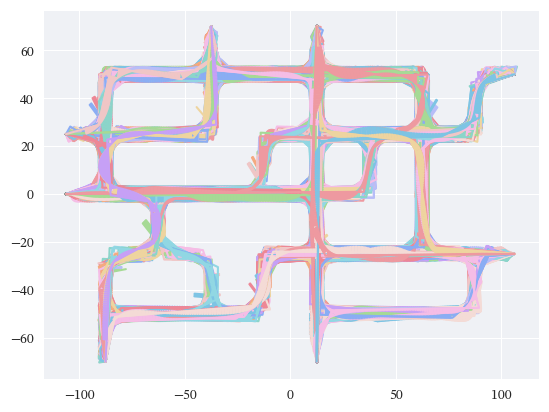

In [15]:

# empty polars dataframe with header ["robot_id", "tracking", "seed", "rmse"]
df = pl.DataFrame(schema={
    "robot_id": pl.String,
    "tracking": pl.Boolean,
    "sigma": pl.Float64,
    "seed": pl.Int64,
    "rmse": pl.Float64
})

for directory in RESULTS_DIRS:

    # rmses: list[float] = []
    rmse_true: dict[str, float] = {}
    rmse_false: dict[str, float] = {}
    # rmse_of_each_robot: dict[str, float] = {}
    for file in RESULTS_DIR.glob('*.json'):
        match = RE.match(file.name)
        assert match is not None
        tracking = str(match.group(1))
        sigma = float(match.group(2))
        seed = int(match.group(3))
    
        data = json.loads(file.read_text())

        for robot_id, robot_data in data['robots'].items():
            color: str = robot_data['color']
            positions = np.array([p for p in robot_data['positions']])
            mission = robot_data['mission']
            waypoints = []
            for route in mission['routes']:
                waypoints.append(route['waypoints'][0])
                for wp in route['waypoints'][1:]:
                    waypoints.append(wp)

            waypoints = np.array(waypoints)
            waypoints = np.squeeze(waypoints)

            x_coords = []
            y_coords = []
            projection_x_coords = []
            projection_y_coords = []

            lines: list[LinePoints] = [LinePoints(start=start, end=end) for start, end in sliding_window(waypoints, 2)]
            closest_projections = [closest_projection_onto_line_segments(p, lines) for p in positions]

            # plot a solid lines of all waypoints
            plt.plot(waypoints[:, 0], waypoints[:, 1], linestyle='solid', color=color, label=f'Robot {robot_id}')

            # plot a dashed line from each point to closest projection
            for p, cp in zip(positions, closest_projections):
                x_coords.append(p[0])
                y_coords.append(p[1])
                projection_x_coords.append(cp[0])
                projection_y_coords.append(cp[1])

                #plot line to closest projection
                plt.plot([p[0], cp[0]], [p[1], cp[1]], color=color)

            error: float = np.sum(np.linalg.norm(positions - closest_projections, axis=1))
            rmse: float = np.sqrt(error / len(positions))

            # if tracking == 'true':
            #     rmse_true[f"{robot_id}-{tracking}-{seed}"] = rmse
            # else:
            #     rmse_false[f"{robot_id}-{tracking}-{seed}"] = rmse

            df2 = pl.DataFrame({
                "robot_id": [robot_id],
                "tracking": [tracking == "true"],
                "sigma": [sigma],
                "seed": [seed],
                "rmse": [rmse]
            })

            # print(df2)

            # put into dataframe
            df.extend(df2)
    

shape: (500, 5)
┌─────────────┬──────────┬───────┬──────┬──────────┐
│ robot_id    ┆ tracking ┆ sigma ┆ seed ┆ rmse     │
│ ---         ┆ ---      ┆ ---   ┆ ---  ┆ ---      │
│ str         ┆ bool     ┆ f64   ┆ i64  ┆ f64      │
╞═════════════╪══════════╪═══════╪══════╪══════════╡
│ 12884902542 ┆ false    ┆ 0.15  ┆ 227  ┆ 1.326272 │
│ 12884902429 ┆ false    ┆ 0.15  ┆ 227  ┆ 1.204775 │
│ 17179869990 ┆ false    ┆ 0.15  ┆ 227  ┆ 1.154555 │
│ 21474836689 ┆ false    ┆ 0.15  ┆ 227  ┆ 1.200876 │
│ 8589935242  ┆ false    ┆ 0.15  ┆ 227  ┆ 1.008181 │
│ …           ┆ …        ┆ …     ┆ …    ┆ …        │
│ 12884902303 ┆ false    ┆ 0.15  ┆ 805  ┆ 1.150332 │
│ 25769803970 ┆ false    ┆ 0.15  ┆ 805  ┆ 1.181009 │
│ 8589934601  ┆ false    ┆ 0.15  ┆ 805  ┆ 1.077765 │
│ 21474837601 ┆ false    ┆ 0.15  ┆ 805  ┆ 1.218632 │
│ 25769804472 ┆ false    ┆ 0.15  ┆ 805  ┆ 1.042123 │
└─────────────┴──────────┴───────┴──────┴──────────┘

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 500.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 1.003978  │
│ std        ┆ 0.230388  │
│ min        ┆ 6.5345e-8 │
│ 25%        ┆ 0.898321  │
│ 50%        ┆ 1.042123  │
│ 75%        ┆ 1.153165  │
│ max        ┆ 1.464897  │
└────────────┴───────────┘

shape: (1_000, 5)
┌─────────────┬──────────┬───────┬──────┬──────────┐
│ robot_id    ┆ tracking ┆ sigma ┆ seed ┆ rmse     │
│ ---         ┆ ---      ┆ ---   ┆ ---  ┆ ---      │
│ str         ┆ bool     ┆ f64   ┆ i64  ┆ f64      │
╞═════════════╪══════════╪═══════╪══════╪══════════╡
│ 4294967784  ┆ true     ┆ 0.15  ┆ 227  ┆ 0.652898 │
│ 8589935323  ┆ true     ┆ 0.15  ┆ 227  ┆ 0.549957 │
│ 17179869606 ┆ true     ┆ 0.15  ┆ 227  ┆ 0.731728 │
│ 17179869425 ┆ true     ┆ 0.15  ┆ 227  ┆ 0.728862 │
│ 17179869476 ┆ true     ┆ 0.15  ┆ 227  ┆ 0.776779 │
│ …           ┆ …        ┆ …     ┆ …    ┆ …        │
│ 12884902303 ┆ false    ┆ 0.15  ┆ 805  ┆ 1.150332 │
│ 25769803970 ┆ false    ┆ 0.15  ┆ 805  ┆ 1.181009 │
│ 8589934601  ┆ false    ┆ 0.15  ┆ 805  ┆ 1.077765 │
│ 21474837601 ┆ false    ┆ 0.15  ┆ 805  ┆ 1.218632 │
│ 25769804472 ┆ false    ┆ 0.15  ┆ 805  ┆ 1.042123 │
└─────────────┴──────────┴───────┴──────┴──────────┘

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 1000.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.855876  │
│ std        ┆ 0.247935  │
│ min        ┆ 6.5345e-8 │
│ 25%        ┆ 0.695161  │
│ 50%        ┆ 0.842916  │
│ 75%        ┆ 1.045296  │
│ max        ┆ 1.464897  │
└────────────┴───────────┘

shape: (500, 5)
┌─────────────┬──────────┬───────┬──────┬──────────┐
│ robot_id    ┆ tracking ┆ sigma ┆ seed ┆ rmse     │
│ ---         ┆ ---      ┆ ---   ┆ ---  ┆ ---      │
│ str         ┆ bool     ┆ f64   ┆ i64  ┆ f64      │
╞═════════════╪══════════╪═══════╪══════╪══════════╡
│ 38654706831 ┆ true     ┆ 0.5   ┆ 227  ┆ 0.889289 │
│ 38654705958 ┆ true     ┆ 0.5   ┆ 227  ┆ 1.261516 │
│ 17179870032 ┆ true     ┆ 0.5   ┆ 227  ┆ 0.49609  │
│ 21474837421 ┆ true     ┆ 0.5   ┆ 227  ┆ 0.937635 │
│ 34359739072 ┆ true     ┆ 0.5   ┆ 227  ┆ 1.278121 │
│ …           ┆ …        ┆ …     ┆ …    ┆ …        │
│ 8589934776  ┆ true     ┆ 0.5   ┆ 31   ┆ 1.205673 │
│ 8589934891  ┆ true     ┆ 0.5   ┆ 31   ┆ 0.806717 │
│ 17179869757 ┆ true     ┆ 0.5   ┆ 31   ┆ 1.049196 │
│ 4294967876  ┆ true     ┆ 0.5   ┆ 31   ┆ 1.303979 │
│ 21474836878 ┆ true     ┆ 0.5   ┆ 31   ┆ 0.879909 │
└─────────────┴──────────┴───────┴──────┴──────────┘

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 500.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.98681   │
│ std        ┆ 0.212813  │
│ min        ┆ 6.4935e-8 │
│ 25%        ┆ 0.889289  │
│ 50%        ┆ 1.008476  │
│ 75%        ┆ 1.131919  │
│ max        ┆ 1.533094  │
└────────────┴───────────┘

/tmp/ipykernel_57499/220776453.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontdict={'color': flavor.text.hex}, fontproperties=prop_jbm)
/tmp/ipykernel_57499/220776453.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


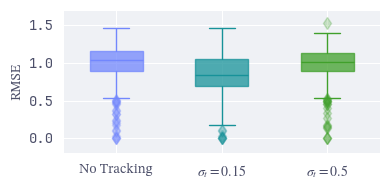

In [26]:


df_no_tracking = df.filter(pl.col("tracking") == False)
df_low_sigma = df.filter(pl.col("sigma") <= 0.15)
df_high_sigma = df.filter(pl.col("sigma") > 0.15)

for d in [df_no_tracking, df_low_sigma, df_high_sigma]:
    print(d)
    print(d['rmse'].describe())

# make box plots

fig, ax = plt.subplots(figsize=(4,2))

offset = 0.2

def set_box_plot_color(bp, color, alpha):
    # style the outliers
    # plt.setp(bp['fliers'], color=color, markersize=3, marker='.')
    # above color is not working, they are all black do this instead:
    for flier in bp['fliers']:
        flier.set(marker='d', markerfacecolor=color, markeredgecolor=None, alpha=0.5 * alpha)

    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        base_alpha = 1.0
        if element == 'boxes':
            base_alpha = 0.75
        elif element == 'fliers':
            base_alpha = 0.25
        plt.setp(bp[element], color=color, alpha=base_alpha * alpha)

for i, (d, (c, alpha, _, _)) in enumerate(zip([df_no_tracking, df_low_sigma, df_high_sigma], colors)):
    rmse = d['rmse'].to_numpy()

    bp = ax.boxplot([rmse], positions=[i], widths=0.5, patch_artist=True)
    set_box_plot_color(bp, c, alpha)

ax.set_ylim(-0.2, 1.7)

ax.set_ylabel('RMSE', fontdict={'color': flavor.text.hex})
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['No Tracking', '$\sigma_t = 0.15$', '$\sigma_t = 0.5$'], fontdict={'color': flavor.text.hex})

ax.set_yticklabels(ax.get_yticks(), fontdict={'color': flavor.text.hex}, fontproperties=prop_jbm)

# y ticks
plt.yticks(color=flavor.text.hex)

fig.tight_layout()
fig.savefig('./scripts/out/collaborative-gp.svg')

fig.show()

In [ ]:
p1 = [1.0, 0.0]
p2 = [-1.0, 1.0]
abs( np.arctan2(p1[0], p1[1]) - np.arctan2(p2[0], p2[1]) ) >= np.pi / 2

True

/tmp/ipykernel_14450/1995776856.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


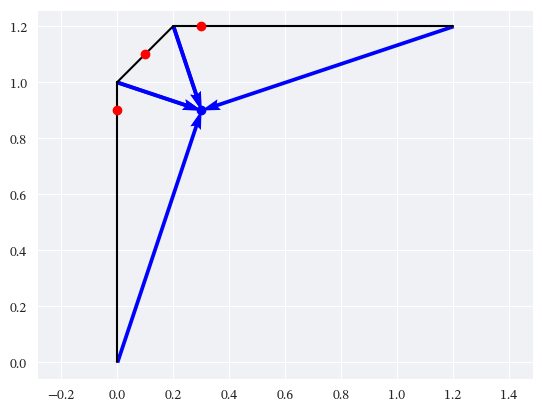

In [ ]:
lines: List[LinePoints] = [
    LinePoints(start=[0, 0], end=[0, 1]),
    LinePoints(start=[0, 1], end=[0.2, 1.2]),
    LinePoints(start=[0.2, 1.2], end=[1.2, 1.2]),
]

point = np.array([.3, 0.9])

fig, ax = plt.subplots()

# plot point
ax.plot(point[0], point[1], 'o', color='blue')

for line in lines:
    # plot line
    start = line.start
    end = line.end
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black')
    # ax.plot([line.start[0], line.end[0]], [line.start[1], line.end[1]], color='black')

    v1 = point - line.start
    v2 = point - line.end

    # projection onto line
    # line_segment = line_from_line_segment(line.start[0], line.start[1], line.end[0], line.end[1])
    projection = projection_onto_line(point, line)

    # plot projection
    ax.plot(projection[0], projection[1], 'o', color='red')

    # plot vectors
    ax.quiver(*start, *v1, angles='xy', scale_units='xy', scale=1, color='blue')
    ax.quiver(*end, *v2, angles='xy', scale_units='xy', scale=1, color='blue')

# equal axis
ax.axis('equal')

fig.show()


In [ ]:

    
data = json.loads(RESULTS_DIRS[0].read_text())

rmses: list[float] = []
rmse_true: dict[str, float] = {}

for robot_id, robot_data in data['robots'].items():
    color: str = robot_data['color']
    positions = np.array([p for p in robot_data['positions']])
    mission = robot_data['mission']
    waypoints = []
    for route in mission['routes']:
        waypoints.append(route['waypoints'][0])
        for wp in route['waypoints'][1:]:
            waypoints.append(wp)

    # print(waypoints)

    # waypoints = np.array([wp for wp in (route['waypoints'] for route in mission['routes'])])
    waypoints = np.array(waypoints)

    waypoints = np.squeeze(waypoints)

    x_coords = []
    y_coords = []
    projection_x_coords = []
    projection_y_coords = []

    lines: list[Line] = [line_from_line_segment(*start, *end) for start, end in sliding_window(waypoints, 2)]
    closest_projections = [closest_projection_onto_line_segments(p, lines) for p in positions]

    # plot a solid lines of all waypoints
    # plt.plot(waypoints[:, 0], waypoints[:, 1], linestyle='solid', color=color)
    plt.plot(waypoints[:, 0], waypoints[:, 1], linestyle='solid', color=color, label=f'Robot {robot_id}')

    # plot a dashed line from each point to closest projection
    for p, cp in zip(positions, closest_projections):
        # plt.plot([p[0], cp[0]], [p[1], cp[1]], linestyle='dashed', color='red')
        x_coords.append(p[0])
        y_coords.append(p[1])
        projection_x_coords.append(cp[0])
        projection_y_coords.append(cp[1])

    error: float = np.sum(np.linalg.norm(positions - closest_projections, axis=1))
    rmse: float = np.sqrt(error / len(positions))

    for ((p1, cp1), (p2, cp2)) in sliding_window(zip(positions, closest_projections), 2):
        # plt.fill([p1[0], cp1[0], cp2[0], p2[0]], [p1[1], cp1[1],  cp2[1], p2[1]], color=color, alpha=0.3)
        # plt.fill([p])
        xs = [p1[0], p2[0], cp1[0], cp2[0]]
        ys = [p1[1], p2[1], cp1[1], cp2[1]]
        # xs = [p2[0], p1[0], cp2[0], cp1[0]]
        # ys = [p2[1], p1[1], cp2[1], cp1[1]]
        # xs = [cp1[0], cp2[0], p2[0], p1[0]]
        # ys = [cp1[1], cp2[1], p2[1], p1[1]]
        # xs = [cp2[0], cp1[0], p2[0], p1[0]]
        # ys = [cp2[1], cp1[1], p2[1], p1[1]]
        # xs = [cp2[0], cp1[0], p2[0], p1[0]]
        # ys = [cp2[1], cp1[1], p2[1], p1[1]]
        plt.fill(xs, ys, color=color, alpha=0.3)



    # print(f"{robot_id} RMSE: {rmse:.3f}")
    rmse_true[robot_id] = rmse

mean: float = statistics.mean(rmse_true.values())
median: float = statistics.median(rmse_true.values())
largest: float = max(rmse_true.values())
smallest: float = min(rmse_true.values())
variance: float = statistics.variance(rmse_true.values())
stdev: float = statistics.stdev(rmse_true.values())
N: int = len(rmse_true)

stats = dict(
    robots=N,
    mean=mean,
    median=median,
    largest=largest,
    smallest=smallest,
    variance=variance,
    stdev=stdev
)

headers = ['Robot ID', 'RMSE']
table = [[robot_id, f"{rmse:.3f}"] for robot_id, rmse in rmse_true.items()]
tabulate_opts = dict(
    tablefmt="mixed_outline",
    showindex="always"
)
# print(tabulate(table, headers, tablefmt="mixed_outline"))
print(tabulate(table, headers, **tabulate_opts))

print(tabulate([stats], headers="keys", **tabulate_opts))



plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

IsADirectoryError: [Errno 21] Is a directory: 'experiments/solo-gp'